# Circuit-Cutting with Cutqc2

This notebook illustrates the use of `Cutqc2` to cut, save and run quantum circuits (`qiskit.QuantumCircuit` objects) and reconstruct the probability state vector of the original uncut circuit.

In [2]:
from math import pi

import qiskit

from cutqc2.core.cut_circuit import CutCircuit

## The uncut circuit

The circuit we intend to cut is a regular `qiskit.QuantumCircuit` object. Here we create a simple circuit corresponding to Figure 4 in the original CutQC paper.

In [3]:
def example_circuit():
    qc = qiskit.QuantumCircuit(5)
    qc.reset(0)
    qc.reset(1)
    qc.reset(2)
    qc.reset(3)
    qc.reset(4)

    qc.h(0)
    qc.h(1)
    qc.h(2)
    qc.h(3)
    qc.h(4)

    qc.cz(0, 1)
    qc.t(2)
    qc.t(3)
    qc.t(4)

    qc.cz(0, 2)
    qc.rx(pi / 2, 4)

    qc.rx(pi / 2, 0)
    qc.rx(pi / 2, 1)
    qc.cz(2, 4)

    qc.t(0)
    qc.t(1)
    qc.cz(2, 3)
    qc.rx(pi / 2, 4)

    qc.h(0)
    qc.h(1)
    qc.h(2)
    qc.h(3)
    qc.h(4)

    return qc


circuit = example_circuit()

## The `CutCircuit` class

We create a `CutCircuit` object by providing it with a `qiskit.QuantumCircuit` object using the `circuit` parameter in the constructor. Initialization using `qasm3` strings is also possible.

In [4]:
cut_circuit = CutCircuit(circuit=circuit)

The uncut circuit is a `qiskit.QuantumCircuit` object, and stored as the `circuit` attribute of `cut_circuit`. Let's draw it out.

In [5]:
print(cut_circuit.circuit.draw(fold=-1))

          ┌───┐                ┌─────────┐   ┌───┐   ┌───┐
q_0: ─|0>─┤ H ├──■───────■─────┤ Rx(π/2) ├───┤ T ├───┤ H ├
          ├───┤  │       │     ├─────────┤   ├───┤   ├───┤
q_1: ─|0>─┤ H ├──■───────┼─────┤ Rx(π/2) ├───┤ T ├───┤ H ├
          ├───┤┌───┐     │     └─────────┘   └───┘   ├───┤
q_2: ─|0>─┤ H ├┤ T ├─────■──────────■──────────■─────┤ H ├
          ├───┤├───┤                │          │     ├───┤
q_3: ─|0>─┤ H ├┤ T ├────────────────┼──────────■─────┤ H ├
          ├───┤├───┤┌─────────┐     │     ┌─────────┐├───┤
q_4: ─|0>─┤ H ├┤ T ├┤ Rx(π/2) ├─────■─────┤ Rx(π/2) ├┤ H ├
          └───┘└───┘└─────────┘           └─────────┘└───┘


### Cutting

Perform circuit-cutting by invoking the `cut` method. Pay attention to the parameters to this method. The `num_subcircuits` parameter is a list of integers, indicating the number of subcircuits for the optimizer to try.

In [6]:
cut_circuit.cut(
    max_subcircuit_width=3,  # Max qubits per subcircuit
    max_cuts=1,  # Max total cuts in the circuit
    num_subcircuits=[2],  # Desired number of subcircuits to try
)

(INFO) (cut_circuit.py) (26-Sep-25 17:20:07) Trying with 2 subcircuits
Set parameter Username
(INFO) (mip.py) (26-Sep-25 17:20:07) Set parameter Username
Set parameter LicenseID to value 2646086
(INFO) (mip.py) (26-Sep-25 17:20:07) Set parameter LicenseID to value 2646086
Academic license - for non-commercial use only - expires 2026-04-01
(INFO) (mip.py) (26-Sep-25 17:20:07) Academic license - for non-commercial use only - expires 2026-04-01


Printing the `cut_circuit` object gives us the location of the auto-placed cuts (as the placeholder `//` gates).

In [6]:
print(cut_circuit)

          ┌───┐                   ┌─────────┐┌───┐   ┌───┐        
q_0: ─|0>─┤ H ├──■──────────────■─┤ Rx(π/2) ├┤ T ├───┤ H ├────────
          ├───┤  │  ┌─────────┐ │ └──┬───┬──┘├───┤   └───┘        
q_1: ─|0>─┤ H ├──■──┤ Rx(π/2) ├─┼────┤ T ├───┤ H ├────────────────
          ├───┤┌───┐└─────────┘ │    ├───┴┐  └───┘           ┌───┐
q_2: ─|0>─┤ H ├┤ T ├────────────■────┤ // ├────■───────■─────┤ H ├
          ├───┤├───┤                 └────┘    │       │     ├───┤
q_3: ─|0>─┤ H ├┤ T ├───────────────────────────┼───────■─────┤ H ├
          ├───┤├───┤┌─────────┐                │  ┌─────────┐├───┤
q_4: ─|0>─┤ H ├┤ T ├┤ Rx(π/2) ├────────────────■──┤ Rx(π/2) ├┤ H ├
          └───┘└───┘└─────────┘                   └─────────┘└───┘


### Subcircuits

Once cut, the individual subcircuits (`qiskit.QuantumCircuit` objects), can be printed.

In [7]:
for subcircuit in cut_circuit.subcircuits:
    print(subcircuit.draw(fold=-1))

          ┌───┐                   ┌─────────┐┌───┐┌───┐
q_0: ─|0>─┤ H ├──■──────────────■─┤ Rx(π/2) ├┤ T ├┤ H ├
          ├───┤  │  ┌─────────┐ │ └──┬───┬──┘├───┤└───┘
q_1: ─|0>─┤ H ├──■──┤ Rx(π/2) ├─┼────┤ T ├───┤ H ├─────
          ├───┤┌───┐└─────────┘ │    └───┘   └───┘     
q_2: ─|0>─┤ H ├┤ T ├────────────■──────────────────────
          └───┘└───┘                                   
                                        ┌───┐        
q_0: ───────────────────────────■──■────┤ H ├────────
          ┌───┐┌───┐┌─────────┐ │  │ ┌──┴───┴──┐┌───┐
q_1: ─|0>─┤ H ├┤ T ├┤ Rx(π/2) ├─■──┼─┤ Rx(π/2) ├┤ H ├
          ├───┤├───┤└─────────┘    │ └──┬───┬──┘└───┘
q_2: ─|0>─┤ H ├┤ T ├───────────────■────┤ H ├────────
          └───┘└───┘                    └───┘        


### Running

Subcircuits of a `CutCircuit` object can be run using the `run_subcircuits()` method.

In [8]:
# Run all the subcircuits - by default we use the `statevector_simulator` backend from qiskit.
cut_circuit.run_subcircuits()

(INFO) (cut_circuit.py) (18-Sep-25 09:43:06) Running subcircuit 0 on backend: statevector_simulator
(INFO) (cut_circuit.py) (18-Sep-25 09:43:06) Running subcircuit 1 on backend: statevector_simulator


### Saving

The `CutCircuit` object (along with the state vectors of its subcircuits) can be saved using the `to_file()` method. Currently, the `zarr` format is supported.

In [9]:
cut_circuit.to_file("cut_circuit.zarr")

/media/vineetb/delta/projects/cutqc2/.venv/lib/python3.12/site-packages/zarr/core/dtype/npy/structured.py:318: UnstableSpecificationWarning: The data type (Structured(fields=(('subcircuit', Int32(endianness='little')), ('qubit', Int32(endianness='little'))))) does not have a Zarr V3 specification. That means that the representation of arrays saved with this data type may change without warning in a future version of Zarr Python. Arrays stored with this data type may be unreadable by other Zarr libraries. Use this data type at your own risk! Check https://github.com/zarr-developers/zarr-extensions/tree/main/data-types for the status of data type specifications for Zarr V3.
  v3_unstable_dtype_warning(self)
/media/vineetb/delta/projects/cutqc2/.venv/lib/python3.12/site-packages/zarr/core/dtype/npy/string.py:248: UnstableSpecificationWarning: The data type (FixedLengthUTF32(length=20, endianness='little')) does not have a Zarr V3 specification. That means that the representation of arrays

### Loading

A previously saved `CutCircuit` object can be loaded using the `from_file` static method of `CutCircuit`.

In [10]:
cut_circuit = CutCircuit.from_file("cut_circuit.zarr")

### Reconstruction

The *reconstruction* process - calculating the state vector of the original uncut circuit using the individual subcircuit state vectors, can be invoked by using the `postprocess` method of the `CutCircuit` class.

The `capacity` parameter indicates the number of qubits we are able to hold in memory at a time during the reconstruction process. The reconstructed state vector will be of size $2^{capacity}$.

The `max_recursion` parameter is a measure of how many iterations of reconstruction we're willing to perform. A greater value of `max_recursion` will allow for better reconstruction.

`capacity`/`max_recursion` are specify tradeoffs between space- and time- complexity of the reconstruction process.

In [11]:
cut_circuit.postprocess(capacity=3, max_recursion=9)

(INFO) (cut_circuit.py) (18-Sep-25 09:43:07) Postprocessing the cut circuit
(INFO) (cut_circuit.py) (18-Sep-25 09:43:07) Starting dynamic definition run
(INFO) (dynamic_definition.py) (18-Sep-25 09:43:07) Calculating initial probabilities for qubit spec AAAMM
(INFO) (cut_circuit.py) (18-Sep-25 09:43:07) Computing probabilities for qubit spec AAAMM
(INFO) (cut_circuit.py) (18-Sep-25 09:43:07)   Processed 0/4 initializations
(INFO) (dynamic_definition.py) (18-Sep-25 09:43:07) recursion_level=1, qubit_spec='AAAMM'
(INFO) (cut_circuit.py) (18-Sep-25 09:43:07) Computing probabilities for qubit spec 00000
(INFO) (cut_circuit.py) (18-Sep-25 09:43:07)   Processed 0/4 initializations
(INFO) (cut_circuit.py) (18-Sep-25 09:43:07) Computing probabilities for qubit spec 00001
(INFO) (cut_circuit.py) (18-Sep-25 09:43:07)   Processed 0/4 initializations
(INFO) (cut_circuit.py) (18-Sep-25 09:43:07) Computing probabilities for qubit spec 00010
(INFO) (cut_circuit.py) (18-Sep-25 09:43:07)   Processed 0/

### Verification

For small quantum circuits, we can verify that the reconstructed state vector along with the ground truth state vector (determined by running the uncut qiskit circuit against the `statevector_simulator` backend).

In [12]:
probabilities = cut_circuit.get_probabilities()
error = cut_circuit.verify(probabilities, raise_error=False)
print(f"Verification error: {error}")

(INFO) (cut_circuit.py) (18-Sep-25 09:43:07) Converting quasi to real probabilities
(INFO) (conversions.py) (18-Sep-25 09:43:07) Computing nearest probability distribution
(INFO) (conversions.py) (18-Sep-25 09:43:07) Sorting
(INFO) (conversions.py) (18-Sep-25 09:43:07) Computed nearest probability distribution
(INFO) (cut_circuit.py) (18-Sep-25 09:43:07) Verifying cut circuit against original circuit
(INFO) (cut_circuit.py) (18-Sep-25 09:43:07) Evaluating ground truth using statevector_simulator
Verification error: 2.7382709336055705e-15


/tmp/ipykernel_20088/542888601.py:1: UserWarning: Generating all 2^num_qubits states. This may be memory intensive.
  probabilities = cut_circuit.get_probabilities()


### Plotting

For small quantum circuits, we can plot out the reconstructed state vector along with the ground truth state vector (determined by running the uncut qiskit circuit against the `statevector_simulator` backend).

(INFO) (cut_circuit.py) (18-Sep-25 09:43:07) Evaluating ground truth using statevector_simulator
(INFO) (cut_circuit.py) (18-Sep-25 09:43:07) Converting quasi to real probabilities
(INFO) (conversions.py) (18-Sep-25 09:43:07) Computing nearest probability distribution
(INFO) (conversions.py) (18-Sep-25 09:43:07) Sorting
(INFO) (conversions.py) (18-Sep-25 09:43:07) Computed nearest probability distribution


/tmp/ipykernel_20088/402829356.py:1: UserWarning: Generating all 2^num_qubits states. This may be memory intensive.
  cut_circuit.plot(plot_ground_truth=True)


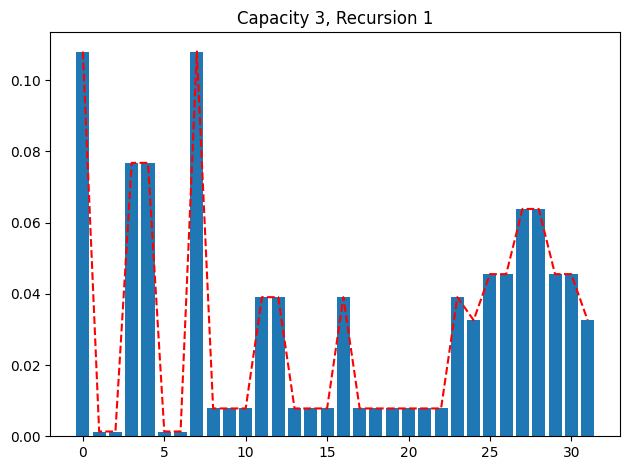

In [13]:
cut_circuit.plot(plot_ground_truth=True)